Trains a simple masked language model with one layer of bert and applies visualization on the results.

In [1]:
from tensorflow import keras
import tensorflow as tf
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import scipy

In [2]:
GPU = True
if GPU: 
    gpus = tf.config.list_physical_devices('GPU')
    cpus = tf.config.list_physical_devices('CPU')
    print("GPUS: ", gpus)
    print("CPUS: ", cpus)
    sys_details = tf.sysconfig.get_build_info()
    cuda = sys_details["cuda_version"]
    cudnn = sys_details["cudnn_version"]
    print("CUDA: ", cuda, "CUDNN: ", cudnn)
else:
    import os
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

GPUS:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
CPUS:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
CUDA:  11.2 CUDNN:  8


2022-03-12 19:49:01.328672: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-03-12 19:49:01.450686: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-03-12 19:49:01.451327: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


# Loads datasets

In [3]:
PATH_DATASETS = "../datasets/nlp/toxicity/"

df_train = pd.read_csv(PATH_DATASETS+ "train.csv")
df_val = pd.read_csv(PATH_DATASETS + "val.csv")
df_test = pd.read_csv(PATH_DATASETS + "test.csv")

# Dataset Generator

In [96]:
class Dataset:
    def __init__(self, texts_to_fit, number_words, batch_size):
        self.number_words = number_words
        self.tokenizer = Tokenizer(num_words=number_words)
        self.tokenizer.fit_on_texts(texts_to_fit)
        self.batch_size = batch_size
        
        self.word2count = self.tokenizer.word_counts
        self.mask_words = []
        
    @property
    def mask_number(self):
        return self.number_words + 1
    
    def mask_data(self, sequences):
        for i in range(len(sequences)):
            while True:
                try:
                    first_not_padding = np.where(sequences[i] != 0)[0][0]

                    mask_index = self.choose_token_at_random(sequences[i]) # random.randint(first_not_padding, len(sequences[i]) - 1)
                    if sequences[i][mask_index] != 0: # padding
                        break
                except IndexError: # In case all are padding
                    mask_index = 0
                    break
            sequences[i][mask_index] = self.mask_number
            
        return sequences
    
    def choose_token_at_random(self, sequence):
        counts = [self.word2count.get(dataset.tokenizer.index_word.get(s), 0) for s in sequence]
        counts = np.asarray(counts)
        counts_norm = 1 / counts
        for i in range(len(sequence)):
            if sequence[i] == 0: # Padding, must not be considered
                counts_norm[i] = -100000 
        
        probs = scipy.special.softmax(counts_norm)
        chosen_index = np.random.choice(len(sequence), 1, p=probs)[0]
        # self.mask_words.append(self.tokenizer.index_word.get(sequence[chosen_index], sequence[chosen_index]))
        return chosen_index
    
    def generate(self, texts_):
        texts = texts_.copy()
        while True:
            i = 0
            np.random.shuffle(texts)
            while (i + self.batch_size) < len(texts):
                texts_sample = texts[i: i + self.batch_size]

                texts_tokenized = self.tokenizer.texts_to_sequences(texts_sample)
                max_length = max([len(x) for x in texts_tokenized])
                padded_data = pad_sequences(texts_tokenized, maxlen=max_length)
                x_data = self.mask_data(padded_data)
                y_data = padded_data

                mask_data = ~np.isin(x_data, [0, self.mask_number])
                order_data = np.asarray([np.arange(max_length) for _ in texts_sample])
                x_data = np.expand_dims(x_data, 1)
                order_data =  np.expand_dims(order_data, 1)
                yield ({"input": x_data, "mask": mask_data, "order_input": order_data}, y_data)
                i = i + self.batch_size


In [97]:
dataset = Dataset(df_train["comment_text"], number_words=3_000, batch_size=64)

/tmp/ipykernel_14359/3837055476.py:34: RuntimeWarning: divide by zero encountered in true_divide
  counts_norm = 1 / counts


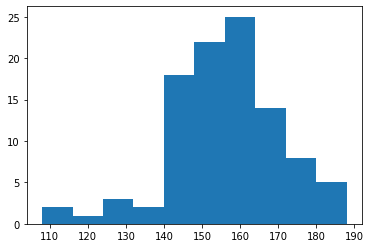

In [98]:
x = dataset.generate(df_train["comment_text"])
lengths = []
for i in range(100):
    y = next(x)
    lengths.append(y[0]["input"].shape[2])
plt.hist(lengths);

# Train model

In [99]:
MAX_LENGTH = 1_000
NUMBER_WORDS = 3_000
EMBEDDING_SIZE = 30
NUM_HEADS = 5

In [100]:
def get_pos_encoding_matrix(max_len, d_emb):
    pos_enc = np.array(
        [
            [pos / np.power(10000, 2 * (j // 2) / d_emb) for j in range(d_emb)]
            if pos != 0
            else np.zeros(d_emb)
            for pos in range(max_len)
        ]
    )
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2])  # dim 2i
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2])  # dim 2i+1
    return pos_enc


In [101]:
input_ = keras.layers.Input(shape=(None, 1), name="input")
mask_input = keras.layers.Input(shape=(None, ), name="mask", dtype="bool")
order_input =  keras.layers.Input(shape=(None, 1), name="order_input")


word_embedder = keras.layers.Embedding(NUMBER_WORDS + 2, EMBEDDING_SIZE, name="embedding")

position_embedder = keras.layers.Embedding(
    input_dim=MAX_LENGTH,
    output_dim=EMBEDDING_SIZE,
    weights=[get_pos_encoding_matrix(MAX_LENGTH, EMBEDDING_SIZE)],
    trainable=False,
    name="position_embedding")

position_embeddings = position_embedder(order_input)
position_embeddings = keras.layers.Reshape((-1, EMBEDDING_SIZE), name="reshaping_position_embedding")(position_embeddings)


word_embedding = word_embedder(input_)
word_embedding = keras.layers.Reshape((-1, EMBEDDING_SIZE), name="reshaping")(word_embedding)
word_embedding = word_embedding + position_embeddings


attention_output, attention_scores = keras.layers.Attention(name="atention", dropout=0.3)([word_embedding, word_embedding], mask=[mask_input, mask_input], return_attention_scores=True)

attention_output = keras.layers.BatchNormalization()(attention_output)

ff1 = keras.layers.Dense(EMBEDDING_SIZE, activation="relu")(attention_output)
ff1 = keras.layers.Dropout(0.3)(ff1)
ff2 = keras.layers.Dense(EMBEDDING_SIZE)(ff1)

output = keras.layers.Dense(NUMBER_WORDS + 2, activation="softmax")(ff2)

mask_language_model = keras.models.Model([input_, mask_input, order_input], output, name="masked_model")
mask_language_model.compile("adam", keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE))

In [102]:
mask_language_model.summary()

Model: "masked_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, None, 1)]    0           []                               
                                                                                                  
 order_input (InputLayer)       [(None, None, 1)]    0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 1, 30)  90060       ['input[0][0]']                  
                                                                                                  
 position_embedding (Embedding)  (None, None, 1, 30)  30000      ['order_input[0][0]']            
                                                                                       

In [ ]:

history = mask_language_model.fit(
    dataset.generate(df_train["comment_text"]), epochs=500, steps_per_epoch=len(df_train["comment_text"]) // dataset.batch_size - 1,
    validation_data=dataset.generate(df_test["comment_text"]), validation_steps=len(df_test["comment_text"]) // dataset.batch_size - 1)

/tmp/ipykernel_14359/3837055476.py:34: RuntimeWarning: divide by zero encountered in true_divide
  counts_norm = 1 / counts


Epoch 1/500
280/280 [==============================] - 14s 45ms/step - loss: 1.6149 - val_loss: 1.4173
Epoch 2/500
280/280 [==============================] - 13s 45ms/step - loss: 1.1367 - val_loss: 0.6665
Epoch 3/500
280/280 [==============================] - 13s 45ms/step - loss: 0.8978 - val_loss: 0.4420
Epoch 4/500
280/280 [==============================] - 13s 46ms/step - loss: 0.7789 - val_loss: 0.3231
Epoch 5/500
280/280 [==============================] - 13s 47ms/step - loss: 0.7025 - val_loss: 0.2490
Epoch 6/500
280/280 [==============================] - 13s 47ms/step - loss: 0.6558 - val_loss: 0.1934
Epoch 7/500
280/280 [==============================] - 14s 52ms/step - loss: 0.6167 - val_loss: 0.1517
Epoch 8/500
280/280 [==============================] - 15s 55ms/step - loss: 0.5881 - val_loss: 0.1245
Epoch 9/500
280/280 [==============================] - 15s 55ms/step - loss: 0.5680 - val_loss: 0.1050
Epoch 10/500
280/280 [==============================] - 15s 54ms/step - l

In [ ]:
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()

In [ ]:
mask_language_model.save("mlm_500_epochs")

In [ ]:
import pickle
with open("history_500_epochs.pkl", "wb") as f:
    pickle.dump(history, f)

# Visualization

In [36]:
order_input = mask_language_model.get_layer("order_input").output
attention_scores = mask_language_model.get_layer("atention").output[1]

In [37]:
model_attention_scores = keras.models.Model([input_, mask_input, order_input], attention_scores, name="attention_scores_model")

In [38]:
texts = df_train["comment_text"].values[25]
texts = "you are not the most beautiful person on earth"
texts = "I didn't go to the market yesterday"
texts = df_test["comment_text"].values[10]
# texts = "John passed the test although he had not studied."

inputs = np.asarray(dataset.tokenizer.texts_to_sequences([texts]))

index_word_to_mask = 7

inputs_masked = inputs.copy()
if index_word_to_mask >= 0:
    inputs_masked[0][index_word_to_mask] = NUMBER_WORDS + 1

mask = ~np.isin(inputs_masked, [0, dataset.mask_number])
order_input_ = np.asarray([np.arange(len(inputs_masked[0]))])


In [39]:
attention_scores = np.squeeze(model_attention_scores.predict({"input": inputs, "mask": mask, "order_input": order_input_}))
tokens_in_s = [dataset.tokenizer.index_word.get(s_i, "<PAD>") if (s_i != NUMBER_WORDS + 1) else "<MASK>" for s_i in inputs[0]]
tokens_with_mask = [dataset.tokenizer.index_word.get(s_i, "<PAD>") if (s_i != NUMBER_WORDS + 1) else "<MASK>" for s_i in inputs_masked[0]]

In [40]:
prediction_probs = mask_language_model.predict({"input": inputs, "mask": mask, "order_input": order_input_})[0, :, :]
predictions = np.argmax(prediction_probs, axis=-1)

predictions = [dataset.tokenizer.index_word.get(s_i, "<PAD>") if (s_i != NUMBER_WORDS + 1) else "<MASK>" for s_i in predictions]
print("ORIGINAL TEXT: ", texts)
print("MASKED: ", tokens_with_mask)
print("PREDICTION: ", predictions)

ORIGINAL TEXT:  Is this a joke wasting tax payers money like this. Just stupid and a waste of time. Grow up juneau
MASKED:  ['is', 'this', 'a', 'joke', 'wasting', 'tax', 'payers', '<MASK>', 'like', 'this', 'just', 'stupid', 'and', 'a', 'waste', 'of', 'time', 'grow', 'up']
PREDICTION:  ['is', 'this', 'a', 'joke', 'wasting', 'tax', 'payers', 'to', 'like', 'this', 'just', 'stupid', 'and', 'a', 'waste', 'of', 'time', 'grow', 'up']


In [45]:
n_possiblities = list(zip(*sorted(enumerate(prediction_probs[index_word_to_mask].tolist()), key=lambda x: x[1], reverse=True)[:10]))[0]
[dataset.tokenizer.index_word.get(s_i, "<PAD>") if (s_i != NUMBER_WORDS + 1) else "<MASK>" for s_i in n_possiblities]

['to', 'that', 'a', 'in', 'and', 'for', 'the', 'of', 'on', 'or']

In [28]:
prediction_probs[index_word_to_mask, inputs[0][index_word_to_mask]], max(prediction_probs[index_word_to_mask])

(0.0007690231, 0.04287011)

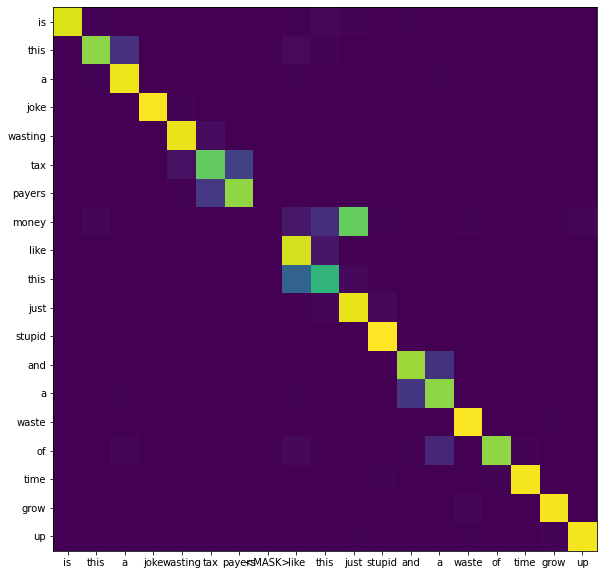

In [29]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(attention_scores)
ax.set_xticks(range(len(tokens_in_s)))
ax.set_yticks(range(len(tokens_in_s)))
ax.set_xticklabels(tokens_with_mask)
ax.set_yticklabels(tokens_in_s);
